# ESM2 Interpretability from CIF

Short summary: This notebook extracts protein sequences from CIF structure files, computes ESM2 sequence embeddings, and trains compact probes to discover which embedding dimensions relate to simple biological properties (secondary structure, surface exposure, flexibility, contacts, hydrophobicity, and charge).

What you'll get: a small set of embedding dimensions linked to each property, visual overlap between properties, prediction quality metrics, and plots that connect embeddings to backbone geometry. The results are meant to help interpret what parts of the ESM2 embedding space encode familiar biological signals.

The ideas in this notebook were inspired from this research paper: https://www.biorxiv.org/content/10.1101/2024.11.14.623630v1.full.pdf

In [13]:
import os, torch, esm, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from Bio.PDB import MMCIFParser, PPBuilder, calc_dihedral, NeighborSearch
from Bio.PDB.DSSP import DSSP
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
cif_dir = './pdbs'

all_X, all_ss, all_rsa = [], [], []
all_phi, all_psi, all_bfactors = [], [], []
all_contacts, all_hydrophobicity, all_charge = [], [], []
all_sequences, all_coords = [], []

# Amino acid properties
aa_hydrophobicity = {
    'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
    'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
}

aa_charge = {
    'A': 0, 'R': 1, 'N': 0, 'D': -1, 'C': 0, 'Q': 0, 'E': -1, 
    'G': 0, 'H': 0.1, 'I': 0, 'L': 0, 'K': 1, 'M': 0, 'F': 0, 
    'P': 0, 'S': 0, 'T': 0, 'W': 0, 'Y': 0, 'V': 0
}

In [ ]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model.eval()
batch_converter = alphabet.get_batch_converter()
parser = MMCIFParser(QUIET=True)
ppb = PPBuilder()

def calculate_phi_psi(residues):
    phi_angles, psi_angles = [], []
    for i, residue in enumerate(residues):
        try:
            if i > 0 and i < len(residues) - 1:
                # Phi angle: C(i-1) - N(i) - CA(i) - C(i)
                phi = calc_dihedral(residues[i-1]['C'].get_vector(),
                                  residue['N'].get_vector(),
                                  residue['CA'].get_vector(),
                                  residue['C'].get_vector())
                # Psi angle: N(i) - CA(i) - C(i) - N(i+1)
                psi = calc_dihedral(residue['N'].get_vector(),
                                  residue['CA'].get_vector(),
                                  residue['C'].get_vector(),
                                  residues[i+1]['N'].get_vector())
                phi_angles.append(phi)
                psi_angles.append(psi)
            else:
                phi_angles.append(0.0)
                psi_angles.append(0.0)
        except:
            phi_angles.append(0.0)
            psi_angles.append(0.0)
    return phi_angles, psi_angles

def calculate_contacts(residues, cutoff=8.0):
    coords = []
    for res in residues:
        try:
            coords.append(res['CA'].get_coord())
        except:
            coords.append(np.array([0, 0, 0]))
    
    coords = np.array(coords)
    distances = squareform(pdist(coords))
    contacts = (distances < cutoff).astype(float)
    
    # Return contact density for each residue
    contact_density = np.sum(contacts, axis=1) / len(contacts)
    return contact_density

## Data Loading

In [ ]:
cif_files = [f for f in os.listdir(cif_dir) if f.endswith('.cif')]
print(f"Found {len(cif_files)} CIF files to process")

for cif in tqdm(cif_files, desc="Processing CIF files"):
    path = os.path.join(cif_dir, cif)
    
    if not os.path.exists(path):
        print(f"Warning: {cif} not found at {path}")
        continue
    
    try:
        struct = parser.get_structure('x', path)
        dssp = DSSP(struct[0], path)
        
        for model0 in struct:
            for chain in model0:
                peptides = ppb.build_peptides(chain)
                residues = list(chain.get_residues())
                
                for pep in peptides:
                    seq = str(pep.get_sequence())
                    if len(seq) < 10:  # Skip very short sequences
                        continue
                        
                    data = [('p', seq)]
                    _, _, toks = batch_converter(data)
                    with torch.no_grad(): 
                        out = model(toks, repr_layers=[33])
                    reps = out['representations'][33][0, 1:len(seq)+1].numpy()
                    
                    # Structural features from DSSP
                    ss, rsa, bfac = [], [], []
                    valid_indices = []
                    
                    for i, key in enumerate(dssp.keys()):
                        if i >= len(seq): break
                        try:
                            ss.append(dssp[key][2])
                            rsa.append(dssp[key][3])
                            # B-factor (temperature factor)
                            bfac.append(residues[i]['CA'].get_bfactor() if i < len(residues) else 50.0)
                            valid_indices.append(i)
                        except:
                            continue
                    
                    if len(valid_indices) < len(seq) * 0.8:  # Skip if too many missing values
                        continue
                    
                    # Calculate dihedral angles
                    phi_angles, psi_angles = calculate_phi_psi(residues[:len(seq)])
                    
                    # Calculate contact density
                    contacts = calculate_contacts(residues[:len(seq)])
                    
                    # Physicochemical properties
                    hydrophob = [aa_hydrophobicity.get(aa, 0) for aa in seq]
                    charges = [aa_charge.get(aa, 0) for aa in seq]
                    
                    # Store all features (only for valid residues)
                    all_X.append(reps[:len(valid_indices)])
                    all_ss.append(np.array(ss))
                    all_rsa.append(np.array(rsa))
                    all_phi.append(np.array(phi_angles[:len(valid_indices)]))
                    all_psi.append(np.array(psi_angles[:len(valid_indices)]))
                    all_bfactors.append(np.array(bfac))
                    all_contacts.append(contacts[:len(valid_indices)])
                    all_hydrophobicity.append(np.array(hydrophob[:len(valid_indices)]))
                    all_charge.append(np.array(charges[:len(valid_indices)]))
                    all_sequences.append(seq[:len(valid_indices)])
                    
    except Exception as e:
        print(f"Error processing {cif}: {e}")
        continue

print(f"Processed {len(all_X)} protein chains")
print(f"Total residues: {sum(len(x) for x in all_X)}")

Found 200 CIF files to process


Processing CIF files:   0%|          | 0/200 [00:00<?, ?it/s]

Processing CIF files: 100%|██████████| 200/200 [1:55:33<00:00, 34.67s/it]    

Processed 1915 protein chains
Total residues: 303804


In [ ]:
X = np.concatenate(all_X)
Y_ss = np.concatenate(all_ss)
Y_rsa = np.concatenate(all_rsa)

Y_rsa_fixed = []
for val in Y_rsa:
    try:
        Y_rsa_fixed.append(float(val))
    except ValueError:
        Y_rsa_fixed.append(0.0)  # Default for non-numeric
Y_rsa = np.array(Y_rsa_fixed)
print(f"Fixed Y_rsa range: [{Y_rsa.min():.3f}, {Y_rsa.max():.3f}]")

Y_phi = np.concatenate(all_phi)
Y_psi = np.concatenate(all_psi)
Y_bfactors = np.concatenate(all_bfactors)
Y_contacts = np.concatenate(all_contacts)
Y_hydrophobicity = np.concatenate(all_hydrophobicity)
Y_charge = np.concatenate(all_charge)

print(f"Feature matrix shape: {X.shape}")
print(f"Unique secondary structures: {np.unique(Y_ss)}")
print(f"RSA range: [{Y_rsa.min():.3f}, {Y_rsa.max():.3f}]")
print(f"Contact density range: [{Y_contacts.min():.3f}, {Y_contacts.max():.3f}]")

Fixed Y_rsa range: [0.000, 1.000]
Feature matrix shape: (303804, 1280)
Unique secondary structures: ['-' 'B' 'E' 'G' 'H' 'I' 'P' 'S' 'T']
RSA range: [0.000, 1.000]
Contact density range: [0.002, 1.000]


In [ ]:
# save processed data to avoid re-running the long processing (115 minutes)

np.savez('processed_data.npz', 
         X=X, Y_ss=Y_ss, Y_rsa=Y_rsa, Y_phi=Y_phi, Y_psi=Y_psi,
         Y_bfactors=Y_bfactors, Y_contacts=Y_contacts, 
         Y_hydrophobicity=Y_hydrophobicity, Y_charge=Y_charge)
print("Data saved to processed_data.npz")

# run this to load it

# with np.load('processed_data.npz') as data:
#     X = data['X']
#     Y_ss = data['Y_ss']
#     Y_rsa = data['Y_rsa']
#     Y_phi = data['Y_phi']
#     Y_psi = data['Y_psi']
#     Y_bfactors = data['Y_bfactors']
#     Y_contacts = data['Y_contacts']
#     Y_hydrophobicity = data['Y_hydrophobicity']
#     Y_charge = data['Y_charge']

# print(np.unique(Y_ss, return_counts=True))

# Y_rsa_fixed = []
# for val in Y_rsa:
#     try:
#         Y_rsa_fixed.append(float(val))
#     except ValueError:
#         Y_rsa_fixed.append(0.0)  # Default for non-numeric
# Y_rsa = np.array(Y_rsa_fixed)
# print(f"Fixed Y_rsa range: [{Y_rsa.min():.3f}, {Y_rsa.max():.3f}]")
# print(Y_rsa[0:10])

(array(['-', 'B', 'E', 'G', 'H', 'I', 'P', 'S', 'T'], dtype='<U1'), array([ 62021,   3289,  46170,  11962, 108724,   2240,   6113,  29643,
        33642]))
Fixed Y_rsa range: [0.000, 1.000]
[1.         0.20710059 0.4084507  0.43661972 0.48969072 0.76209677
 0.17924528 0.48591549 0.20121951 0.25352113]


In [ ]:
probes = {}
results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# 1. Secondary structure (multiclass linear probe)

ss_mask = np.array([s in ["H","E","C"] for s in Y_ss])
X_ss = X[ss_mask]
Y_ss_filt = Y_ss[ss_mask]

clf_ss = LogisticRegression(
    max_iter=100,
    class_weight="balanced",
    n_jobs=-1
)

acc = []
for train, test in kf.split(X_ss):
    clf_ss.fit(X_ss[train], Y_ss_filt[train])
    acc.append(accuracy_score(Y_ss_filt[test], clf_ss.predict(X_ss[test])))

results["secondary_structure"] = np.mean(acc)
joblib.dump(clf_ss, "./models/ss_probe.pkl")
probes["ss"] = clf_ss

# 2. Relative solvent accessibility (regression)

mask = np.isfinite(Y_rsa)
X_rsa = X[mask]
Y_rsa2 = Y_rsa[mask]

rsa_probe = Ridge(alpha=1.0)
r2 = []

for train, test in kf.split(X_rsa):
    rsa_probe.fit(X_rsa[train], Y_rsa2[train])
    r2.append(r2_score(Y_rsa2[test], rsa_probe.predict(X_rsa[test])))

results["rsa"] = np.mean(r2)
joblib.dump(rsa_probe, "./models/rsa_probe.pkl")
probes["rsa"] = rsa_probe

# 3. B-factor (flexibility)

mask = np.isfinite(Y_bfactors)
bf_probe = Ridge(alpha=1.0)

r2 = []
for train, test in kf.split(X[mask]):
    bf_probe.fit(X[mask][train], Y_bfactors[mask][train])
    r2.append(r2_score(Y_bfactors[mask][test], bf_probe.predict(X[mask][test])))

results["bfactor"] = np.mean(r2)
joblib.dump(bf_probe, "./models/bfactor_probe.pkl")
probes["bfactor"] = bf_probe

# 4. Contact density

cd_probe = Ridge(alpha=1.0)
r2 = []

for train, test in kf.split(X):
    cd_probe.fit(X[train], Y_contacts[train])
    r2.append(r2_score(Y_contacts[test], cd_probe.predict(X[test])))

results["contacts"] = np.mean(r2)
joblib.dump(cd_probe, "./models/contacts_probe.pkl")
probes["contacts"] = cd_probe

# 5. Hydrophobicity

hydro_probe = Ridge(alpha=1.0)
r2 = []

for train, test in kf.split(X):
    hydro_probe.fit(X[train], Y_hydrophobicity[train])
    r2.append(r2_score(Y_hydrophobicity[test], hydro_probe.predict(X[test])))

results["hydrophobicity"] = np.mean(r2)
joblib.dump(hydro_probe, "./models/hydro_probe.pkl")
probes["hydro"] = hydro_probe

# 6. Charge

charge_probe = Ridge(alpha=1.0)
r2 = []

for train, test in kf.split(X):
    charge_probe.fit(X[train], Y_charge[train])
    r2.append(r2_score(Y_charge[test], charge_probe.predict(X[test])))

results["charge"] = np.mean(r2)
joblib.dump(charge_probe, "./models/charge_probe.pkl")
probes["charge"] = charge_probe

for k,v in results.items():
    print(f"{k:15s}: {v:.3f}")

secondary_structure: 0.891
rsa            : 0.356
bfactor        : 0.282
contacts       : 0.778
hydrophobicity : 0.965
charge         : 0.963


Charge, Hydrophobicity and secondary structure: Almost perfectly encoded

Contracts: Strong 

RSA and B-Factor: weak (dynamics not purely encoded in sequenec)

## The 20 dimensions that mostly encode biological property

In [51]:
n_dims = 20

# Secondary structure
W_ss = probes["ss"].coef_[0]
top = np.argsort(np.abs(W_ss))[-n_dims:]
# print("Secondary structure (H/E/C):", top)

all_dims = set()

# Regression probes
def top_dims(probe, name):
    w = probe.coef_
    top = np.argsort(np.abs(w).ravel())[-n_dims:]
    for d in top:
        all_dims.add(int(d))

    print(f"{name:15s}: {top}")

top_dims(probes["rsa"], "Surface (RSA)")
top_dims(probes["bfactor"], "Flexibility")
top_dims(probes["contacts"], "Contacts")
top_dims(probes["hydro"], "Hydrophobicity")
top_dims(probes["charge"], "Charge")

print("All occuring dimensions:")
print(sorted(all_dims))

Surface (RSA)  : [ 393 1243  955  910  231  987 1000  198  568  119 1092  881  317 1211
  454 1054 1075  157  197  411]
Flexibility    : [1210  873  343  628  967  908 1215  690  737   18 1161  800  167  372
  423 1127 1252  887  926  810]
Contacts       : [ 616  202  102  742  834  105 1112  581  521  254  188  923  805 1097
  991 1139   53 1216  940  441]
Hydrophobicity : [ 330  942  153  839  546  237  295 1206  892 1212  143  661  423   44
  326  630  547  876  809  883]
Charge         : [ 405 1239   64  952  177 1147  153  904 1118  579  994  445  119 1158
  826  777 1038 1112  318  754]
All occuring dimensions:
[18, 44, 53, 64, 102, 105, 119, 143, 153, 157, 167, 177, 188, 197, 198, 202, 231, 237, 254, 295, 317, 318, 326, 330, 343, 372, 393, 405, 411, 423, 441, 445, 454, 521, 546, 547, 568, 579, 581, 616, 628, 630, 661, 690, 737, 742, 754, 777, 800, 805, 809, 810, 826, 834, 839, 873, 876, 881, 883, 887, 892, 904, 908, 910, 923, 926, 940, 942, 952, 955, 967, 987, 991, 994, 1000, 10

## Plotting 

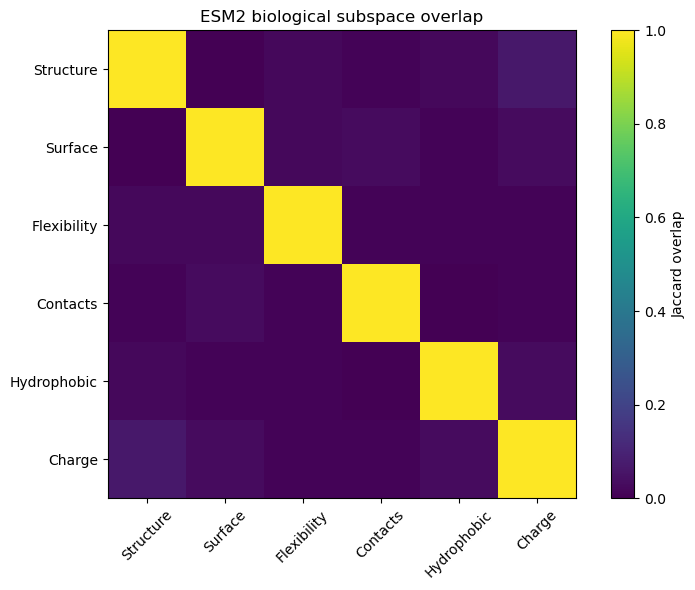

In [53]:
n_dims = 50

dims_dict = {}

# Secondary structure
W_ss = probes["ss"].coef_[0]
dims_dict["Structure"] = np.argsort(np.abs(W_ss))[-n_dims:]

# Regression probes
def get_dims(probe):
    return np.argsort(np.abs(probe.coef_).ravel())[-n_dims:]

dims_dict["Surface"]       = get_dims(probes["rsa"])
dims_dict["Flexibility"]   = get_dims(probes["bfactor"])
dims_dict["Contacts"]      = get_dims(probes["contacts"])
dims_dict["Hydrophobic"]   = get_dims(probes["hydro"])
dims_dict["Charge"]        = get_dims(probes["charge"])


# overlap matrix
props = list(dims_dict.keys())
overlap = np.zeros((len(props), len(props)))

for i,p1 in enumerate(props):
    for j,p2 in enumerate(props):
        s1 = set(dims_dict[p1])
        s2 = set(dims_dict[p2])
        overlap[i,j] = len(s1 & s2) / len(s1 | s2)

plt.figure(figsize=(8,6))
plt.imshow(overlap)
plt.xticks(range(len(props)), props, rotation=45)
plt.yticks(range(len(props)), props)
plt.colorbar(label="Jaccard overlap")
plt.title("ESM2 biological subspace overlap")
plt.tight_layout()
plt.show()

Having this low overlap is great ! It means the model knows well how to seperate dimensions for different physics.

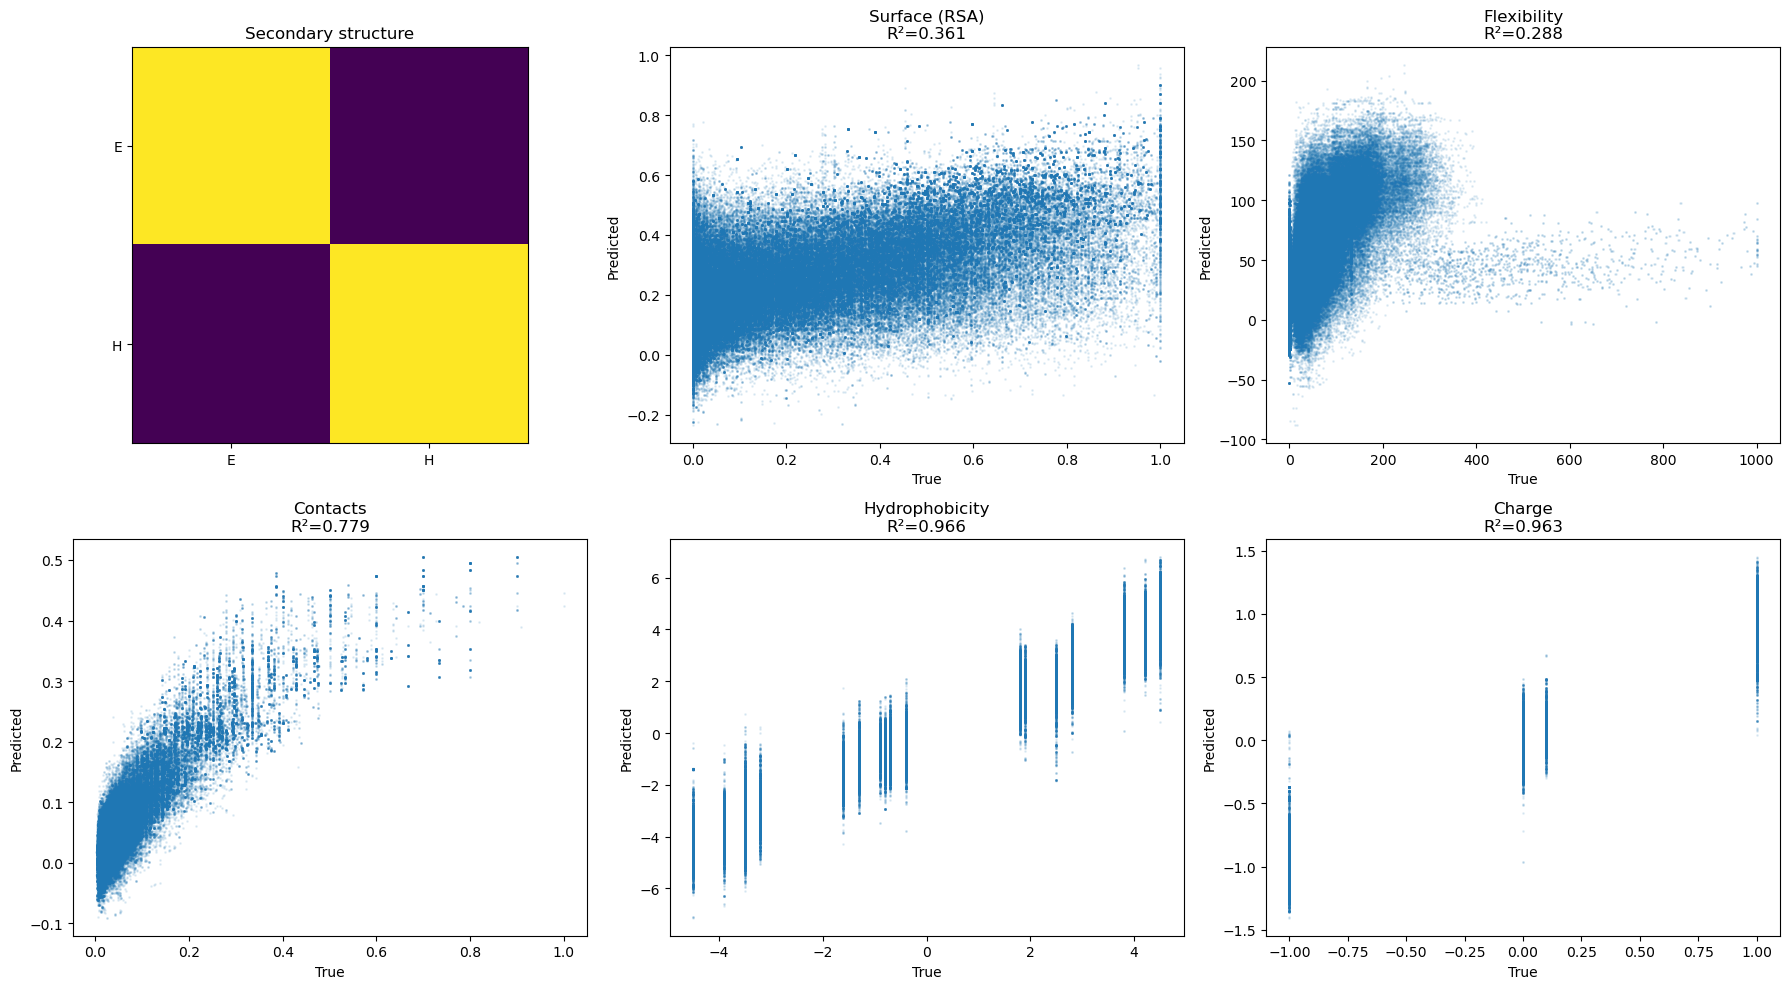

In [ ]:
from sklearn.metrics import confusion_matrix, r2_score
import matplotlib.pyplot as plt

def detailed_performance_analysis():
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    ss_mask = np.array([s in ["H","E","C"] for s in Y_ss])
    X_ss = X[ss_mask]
    Y_ss_f = Y_ss[ss_mask]

    pred = probes["ss"].predict(X_ss)
    cm = confusion_matrix(Y_ss_f, pred, labels=probes["ss"].classes_)
    cm = cm / cm.sum(axis=1, keepdims=True)

    axes[0].imshow(cm)
    axes[0].set_title("Secondary structure")
    axes[0].set_xticks(range(len(probes["ss"].classes_)))
    axes[0].set_yticks(range(len(probes["ss"].classes_)))
    axes[0].set_xticklabels(probes["ss"].classes_)
    axes[0].set_yticklabels(probes["ss"].classes_)

    props = [
        ("Surface (RSA)", "rsa", Y_rsa),
        ("Flexibility", "bfactor", Y_bfactors),
        ("Contacts", "contacts", Y_contacts),
        ("Hydrophobicity", "hydro", Y_hydrophobicity),
        ("Charge", "charge", Y_charge),
    ]

    for i,(name,key,y) in enumerate(props, start=1):
        pred = probes[key].predict(X)
        axes[i].scatter(y, pred, s=1, alpha=0.1)
        axes[i].set_title(f"{name}\nR²={r2_score(y,pred):.3f}")
        axes[i].set_xlabel("True")
        axes[i].set_ylabel("Predicted")

    plt.tight_layout()
    plt.show()

detailed_performance_analysis()

I am satisfied with this result tbh

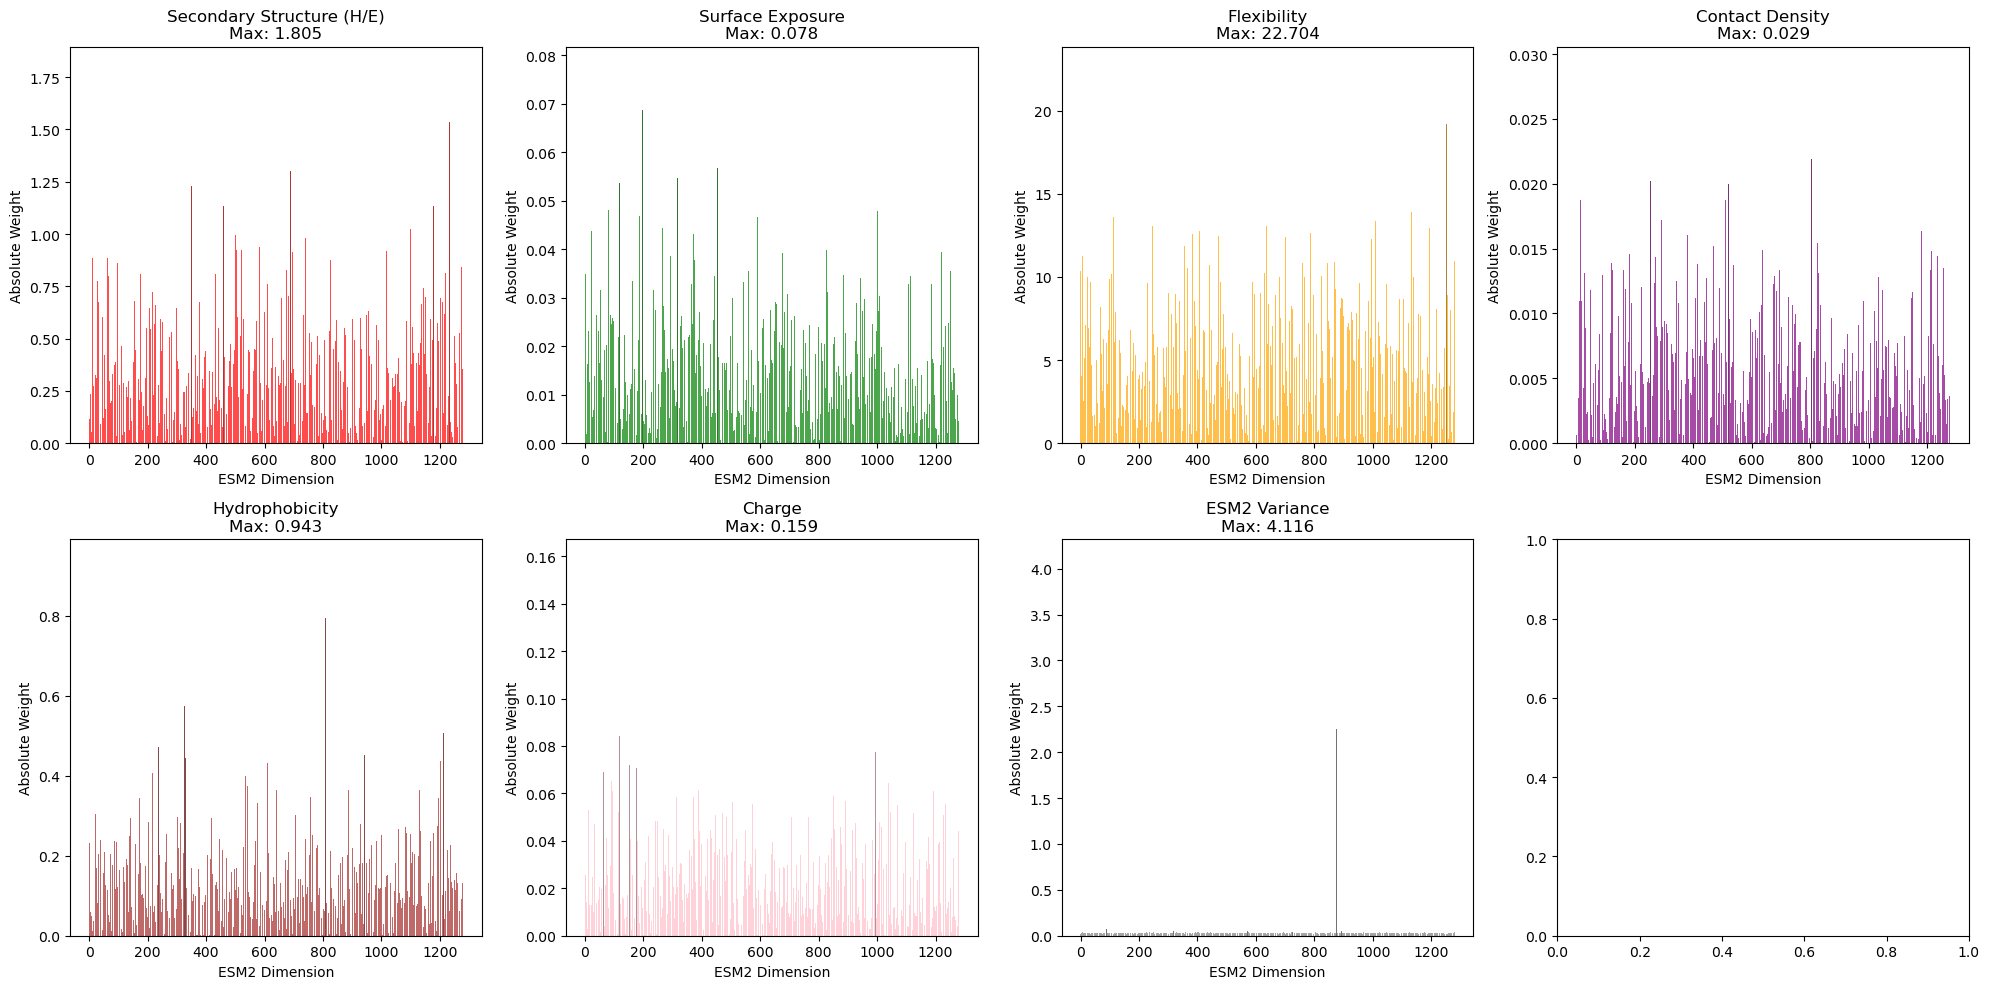

In [55]:
# Feature importance and biological interpretation
def analyze_feature_importance(n_top=20):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    # Secondary structure
    W_ss = probes["ss"].coef_[0]
    
    feature_sets = [
        (W_ss, 'Secondary Structure (H/E)', 'red'),
        (probes["rsa"].coef_.ravel(), 'Surface Exposure', 'green'),
        (probes["bfactor"].coef_.ravel(), 'Flexibility', 'orange'),
        (probes["contacts"].coef_.ravel(), 'Contact Density', 'purple'),
        (probes["hydro"].coef_.ravel(), 'Hydrophobicity', 'brown'),
        (probes["charge"].coef_.ravel(), 'Charge', 'pink'),
        (np.var(X, axis=0), 'ESM2 Variance', 'gray')
    ]
    
    for i, (weights, title, color) in enumerate(feature_sets):
        axes[i].bar(range(len(weights)), np.abs(weights), color=color, alpha=0.7)
        axes[i].set_title(f'{title}\nMax: {np.max(np.abs(weights)):.3f}')
        axes[i].set_xlabel('ESM2 Dimension')
        axes[i].set_ylabel('Absolute Weight')
        
        # Highlight top n_top dimensions
        top_dims = np.argsort(np.abs(weights))[-n_top:]
        for dim in top_dims:
            axes[i].bar(dim, np.abs(weights[dim]), color='black', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_feature_importance()

Well this doesn't give a lot of insight because of the large number of dimensions

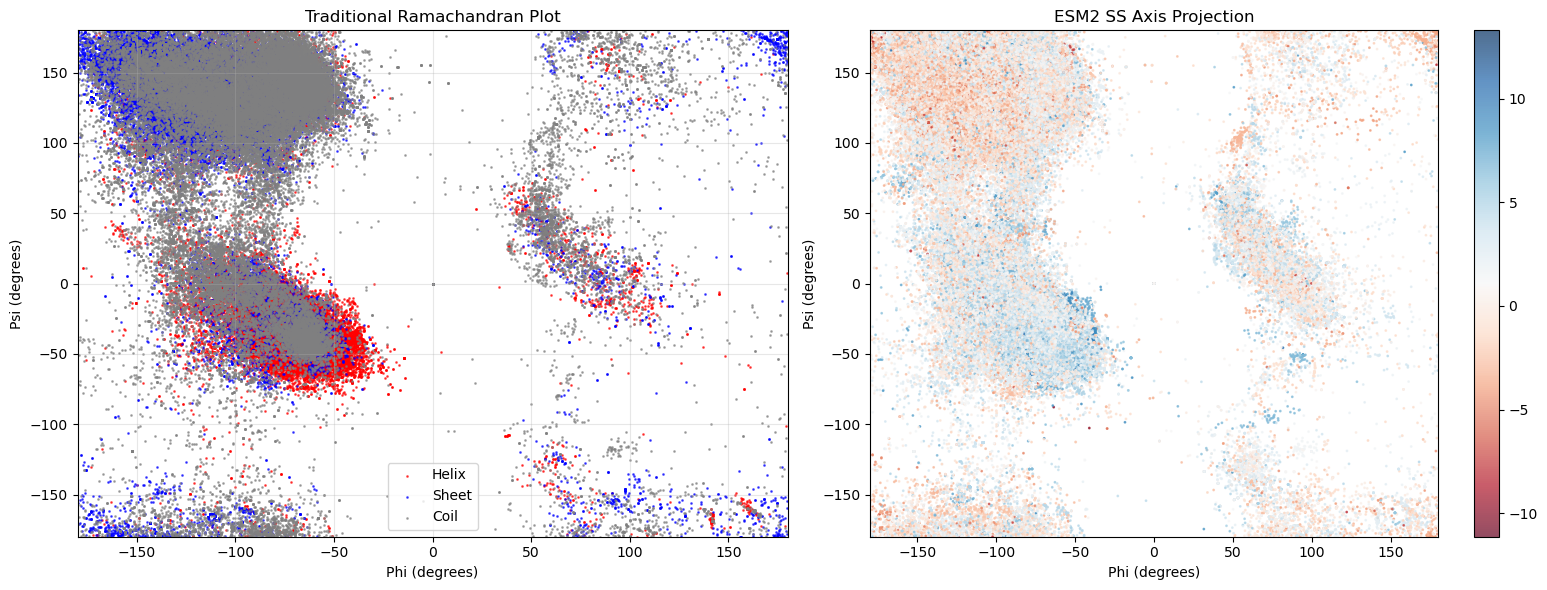

In [56]:
# Ramachandran plot analysis using learned directions
def ramachandran_analysis():
    """Analyze how ESM2 representations relate to backbone geometry"""
    
    # Convert angles to degrees
    phi_deg = np.degrees(Y_phi)
    psi_deg = np.degrees(Y_psi)
    
    # Project ESM2 embeddings onto structural direction
    W_ss = probes["ss"].coef_[0]  # single SS axis
    ss_scores = X @ W_ss  # projection along the learned SS axis
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Traditional Ramachandran plot colored by secondary structure
    for ss_type, color, label in [('H', 'red', 'Helix'), ('E', 'blue', 'Sheet'), ('-', 'gray', 'Coil')]:
        mask = Y_ss == ss_type
        if np.any(mask):
            axes[0].scatter(phi_deg[mask], psi_deg[mask], c=color, alpha=0.6, s=1, label=label)
    
    axes[0].set_xlim(-180, 180)
    axes[0].set_ylim(-180, 180)
    axes[0].set_xlabel('Phi (degrees)')
    axes[0].set_ylabel('Psi (degrees)')
    axes[0].set_title('Traditional Ramachandran Plot')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # ESM2 SS score projection
    scatter = axes[1].scatter(phi_deg, psi_deg, c=ss_scores, cmap='RdBu', s=1, alpha=0.7)
    axes[1].set_xlim(-180, 180)
    axes[1].set_ylim(-180, 180)
    axes[1].set_xlabel('Phi (degrees)')
    axes[1].set_ylabel('Psi (degrees)')
    axes[1].set_title('ESM2 SS Axis Projection')
    plt.colorbar(scatter, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

ramachandran_analysis()

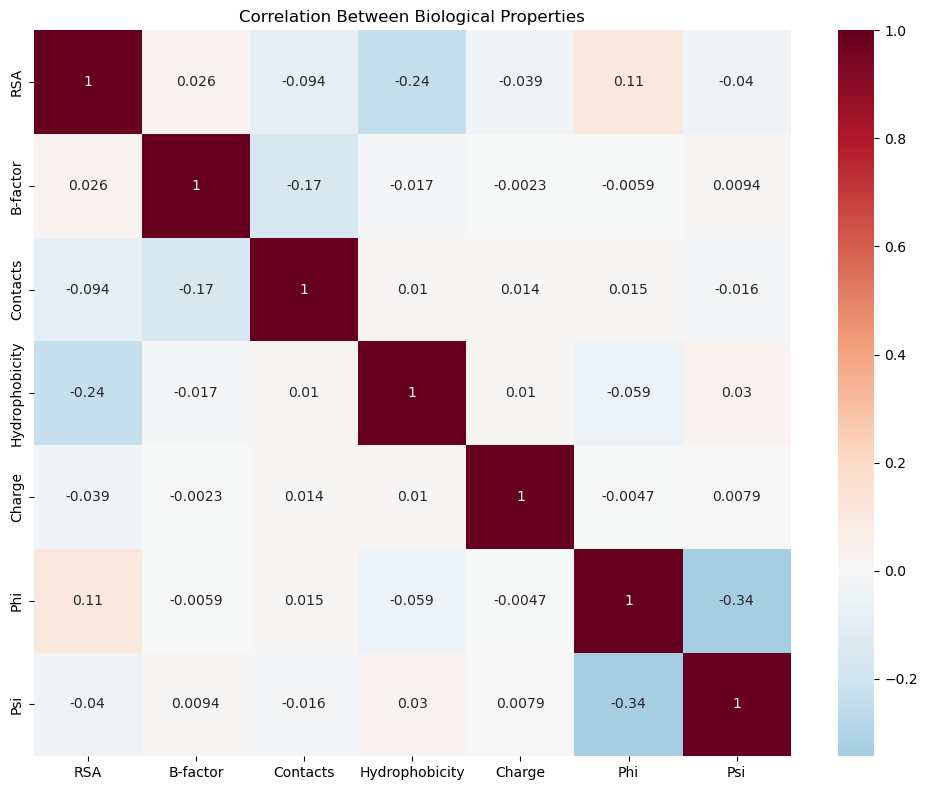

notable corrolations
Phi vs Psi: -0.343


In [58]:
# Correlation analysis between biological properties
def correlation_analysis():
    """Analyze correlations between different biological properties"""
    
    properties_matrix = np.column_stack([
        Y_rsa,
        Y_bfactors, 
        Y_contacts,
        Y_hydrophobicity,
        Y_charge,
        np.degrees(Y_phi),
        np.degrees(Y_psi)
    ])
    
    property_names = ['RSA', 'B-factor', 'Contacts', 'Hydrophobicity', 
                     'Charge', 'Phi', 'Psi']
    
    corr_matrix = np.corrcoef(properties_matrix.T)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                xticklabels=property_names, yticklabels=property_names)
    plt.title('Correlation Between Biological Properties')
    plt.tight_layout()
    plt.show()
    
    print("notable corrolations")
    for i in range(len(property_names)):
        for j in range(i+1, len(property_names)):
            corr = corr_matrix[i, j]
            if abs(corr) > 0.3:
                print(f"{property_names[i]} vs {property_names[j]}: {corr:.3f}")

correlation_analysis()

In [65]:
import json
import numpy as np

dims_mapping = {}
all_dims = set()
n_dims = 20 

probes_list = [
    ("Secondary Structure", probes["ss"]),
    ("Surface (RSA)", probes["rsa"]),
    ("Flexibility", probes["bfactor"]),
    ("Contacts", probes["contacts"]),
    ("Hydrophobicity", probes["hydro"]),
    ("Charge", probes["charge"])
]

while len(all_dims) < X.shape[1]:
    for name, probe in probes_list:
        weights = probe.coef_.ravel()
        top = np.argsort(np.abs(weights))[-n_dims:]
        dims_mapping[name] = list(map(int, top))
        all_dims.update(top)
    n_dims += 5

print(f"All dimensions covered after n_dims={n_dims-5}")
print("Total unique dimensions:", len(all_dims))

with open("esm2_dim_to_biological_property.json", "w") as f:
    json.dump(dims_mapping, f, indent=4)

All dimensions covered after n_dims=905
Total unique dimensions: 1280


With that, we exported our explained models ! This study was done on a part of data, maybe it's not 100% accurate but it gives a strong starting point for our project !